## Run case 1 and case 2 with entire samples

In [21]:
pip install openpyxl

In [6]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# -------------------------------
# Load ROFreq dataset (.xlsx files)
# -------------------------------
def load_chip_data(folder_path):
    all_data, labels = [], []
    for i in range(1, 34):  # Chip1 to Chip33
        file_path = os.path.join(folder_path, f"Chip{i}.xlsx")
        df = pd.read_excel(file_path, header=None)
        tf_rows = df.iloc[[0, 24]].values   # Trojan-Free rows
        ti_rows = df.iloc[1:24].values      # Trojan-Inserted rows
        all_data.extend(tf_rows)
        labels.extend([0] * len(tf_rows))
        all_data.extend(ti_rows)
        labels.extend([1] * len(ti_rows))
    return np.array(all_data), np.array(labels)

# -------------------------------
# Group data by Trojan type
# -------------------------------
def group_by_trojan_type(X, y):
    trojan_groups = {i: [] for i in range(23)}  # 23 Trojan types
    tf_data = []
    for i in range(0, len(X), 25):  # Each chip has 25 rows
        tf_data.append(X[i])        # Row 0 = TF
        tf_data.append(X[i+24])     # Row 24 = TF
        for j in range(23):         # Rows 1–23 = TI
            trojan_groups[j].append(X[i+1+j])
    return np.array(tf_data), trojan_groups

# -------------------------------
# Case 1: Supervised (TF + TI)
# -------------------------------
def evaluate_case1(tf_data, trojan_groups, sample_size, classifier_type='rf'):
    tf_count = sample_size // 2
    ti_count = sample_size // 2
    results, tprs, fprs, times = [], [], [], []

    for _ in range(20):
        tf_train = tf_data[np.random.choice(len(tf_data), tf_count, replace=False)]
        ti_train = []
        ti_eval = []
        for j in range(23):
            samples = np.array(trojan_groups[j])
            selected = samples[np.random.choice(len(samples), ti_count, replace=False)]
            ti_train.extend(selected)
            ti_eval.extend([s for s in samples if s.tolist() not in selected.tolist()])
        X_train = np.vstack([tf_train, ti_train])
        y_train = np.array([0]*tf_count + [1]*len(ti_train))
        X_test = np.vstack([tf_data, ti_eval])
        y_test = np.array([0]*len(tf_data) + [1]*len(ti_eval))

        start = time.time()
        clf = RandomForestClassifier(n_estimators=100) if classifier_type == 'rf' else OneClassSVM(gamma='auto')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if classifier_type == 'ocsvm':
            y_pred = np.where(y_pred == 1, 0, 1)
        end = time.time()

        acc = accuracy_score(y_test, y_pred)
        TP = np.sum((y_test == 1) & (y_pred == 1))
        FN = np.sum((y_test == 1) & (y_pred == 0))
        FP = np.sum((y_test == 0) & (y_pred == 1))
        TN = np.sum((y_test == 0) & (y_pred == 0))
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

        results.append(acc)
        tprs.append(tpr)
        fprs.append(fpr)
        times.append(end - start)

    return np.mean(results), np.mean(tprs), np.mean(fprs), np.mean(times)

# -------------------------------
# Case 2: One-Class (TF only)
# -------------------------------
def evaluate_case2(tf_data, trojan_groups, sample_size, classifier_type='ocsvm'):
    results, tprs, fprs, times = [], [], [], []
    for _ in range(20):
        tf_train = tf_data[np.random.choice(len(tf_data), sample_size, replace=False)]
        ti_eval = []
        for j in range(23):
            ti_eval.extend(trojan_groups[j])
        X_test = np.vstack([tf_data, ti_eval])
        y_test = np.array([0]*len(tf_data) + [1]*len(ti_eval))

        start = time.time()
        if classifier_type == 'rf':
            clf = RandomForestClassifier(n_estimators=100)
            clf.fit(tf_train, [0]*len(tf_train))  # labels all 0
        else:
            clf = OneClassSVM(gamma='auto')
            clf.fit(tf_train)
        y_pred = clf.predict(X_test)
        if classifier_type == 'ocsvm':
            y_pred = np.where(y_pred == 1, 0, 1)
        end = time.time()

        acc = accuracy_score(y_test, y_pred)
        TP = np.sum((y_test == 1) & (y_pred == 1))
        FN = np.sum((y_test == 1) & (y_pred == 0))
        FP = np.sum((y_test == 0) & (y_pred == 1))
        TN = np.sum((y_test == 0) & (y_pred == 0))
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

        results.append(acc)
        tprs.append(tpr)
        fprs.append(fpr)
        times.append(end - start)

    return np.mean(results), np.mean(tprs), np.mean(fprs), np.mean(times)

# -------------------------------
# Run evaluations and collect results
# -------------------------------
def run_all(folder):
    X, y = load_chip_data(folder)
    tf_data, trojan_groups = group_by_trojan_type(X, y)
    sample_sizes = [6, 12, 24]
    classifiers = ['rf', 'ocsvm']
    results_table = []

    for size in sample_sizes:
        print(f"\n=== Sample Size: {size} ===")
        for clf in classifiers:
            acc1, tpr1, fpr1, time1 = evaluate_case1(tf_data, trojan_groups, size, classifier_type=clf)
            acc2, tpr2, fpr2, time2 = evaluate_case2(tf_data, trojan_groups, size, classifier_type=clf)
            results_table.append([size, clf.upper(), acc1, tpr1, fpr1, time1, acc2, tpr2, fpr2, time2])
            print(f"Case 1 | {clf.upper()} | Accuracy: {acc1:.2%} | TPR: {tpr1:.2%} | FPR: {fpr1:.2%} | Time: {time1:.4f}s")
            print(f"Case 2 | {clf.upper()} | Accuracy: {acc2:.2%} | TPR: {tpr2:.2%} | FPR: {fpr2:.2%} | Time: {time2:.4f}s")

    # Convert results to DataFrame for easy plotting
    df = pd.DataFrame(results_table, columns=[
        "Sample Size", "Classifier",
        "Case1_Acc", "Case1_TPR", "Case1_FPR", "Case1_Time",
        "Case2_Acc", "Case2_TPR", "Case2_FPR", "Case2_Time"
    ])
    print("\n=== Comparative Results Table ===")
    print(df)

    # Plot accuracy comparison
    plt.figure(figsize=(10,6))
    for clf in classifiers:
        subset = df[df["Classifier"] == clf.upper()]
        plt.plot(subset["Sample Size"], subset["Case1_Acc"], marker='o', label=f"Case1 {clf.upper()}")
        plt.plot(subset["Sample Size"], subset["Case2_Acc"], marker='s', label=f"Case2 {clf.upper()}")
    plt.xlabel("Sample Size")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison Across Cases and Sample Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot TPR comparison
    plt.figure(figsize=(10,6))
    for clf in classifiers:
        subset = df[df["Classifier"] == clf.upper()]
        plt.plot(subset["Sample Size"], subset["Case1_TPR"], marker='o', label=f"Case1 {clf.upper()} TPR")
        plt.plot(subset["Sample Size"], subset["Case2_TPR"], marker='s', label=f"Case2 {clf.upper()} TPR")
    plt.xlabel("Sample Size")
    plt.ylabel("True Positive Rate")
    plt.title("TPR Comparison Across Cases and Sample Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot FPR comparison
    plt.figure(figsize=(10,6))
    for clf in classifiers:
        subset = df[df["Classifier"] == clf.upper()]
        plt.plot(subset["Sample Size"], subset["Case1_FPR"], marker='o', label=f"Case1 {clf.upper()} FPR")
        plt.plot(subset["Sample Size"], subset["Case2_FPR"], marker='s', label=f"Case2 {clf.upper()} FPR")
    plt.xlabel("Sample Size")
    plt.ylabel("False Positive Rate")
    plt.title("FPR Comparison Across Cases and Sample Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training/evaluation time comparison
    plt.figure(figsize=(10,6))
    for clf in classifiers:
        subset = df[df["Classifier"] == clf.upper()]
        plt.plot(subset["Sample Size"], subset["Case1_Time"], marker='o', label=f"Case1 {clf.upper()} Time")
        plt.plot(subset["Sample Size"], subset["Case2_Time"], marker='s', label=f"Case2 {clf.upper()} Time")
    plt.xlabel("Sample Size")
    plt.ylabel("Average Time (s)")
    plt.title("Training/Evaluation Time Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

def main():
    # Path to your dataset folder (update this to your actual location)
    folder = "ROFreq"

    print("=== Running Trojan Detection Experiments ===")
    print("Dataset: ROFreq (33 chips, 25 rows each, 8 RO frequencies)")
    print("Cases: Case 1 (Supervised), Case 2 (One-Class)")
    print("Classifiers: Random Forest, One-Class SVM")
    print("Sample sizes: 6, 12, 24 (20 trials each)\n")

    # Run all evaluations and collect results
    results_df = run_all(folder)

    # Save results table to CSV for later analysis
    results_df.to_csv("comparative_results.csv", index=False)
    print("\nResults saved to comparative_results.csv")

    # Summary averages across sample sizes
    print("\n=== Summary Averages ===")
    summary = results_df.groupby(["Sample Size", "Classifier"]).mean()
    print(summary)

=== Running Trojan Detection Experiments ===
Dataset: ROFreq (33 chips, 25 rows each, 8 RO frequencies)
Cases: Case 1 (Supervised), Case 2 (One-Class)
Classifiers: Random Forest, One-Class SVM
Sample sizes: 6, 12, 24 (20 trials each)


=== Sample Size: 6 ===
Case 1 | RF | Accuracy: 90.71% | TPR: 97.92% | FPR: 84.24% | Time: 0.0799s
Case 2 | RF | Accuracy: 8.00% | TPR: 0.00% | FPR: 0.00% | Time: 0.0748s
Case 1 | OCSVM | Accuracy: 88.49% | TPR: 96.63% | FPR: 96.14% | Time: 0.0050s
Case 2 | OCSVM | Accuracy: 92.35% | TPR: 99.93% | FPR: 94.85% | Time: 0.0012s

=== Sample Size: 12 ===
Case 1 | RF | Accuracy: 90.48% | TPR: 98.44% | FPR: 83.56% | Time: 0.1100s
Case 2 | RF | Accuracy: 8.00% | TPR: 0.00% | FPR: 0.00% | Time: 0.0863s
Case 1 | OCSVM | Accuracy: 81.07% | TPR: 88.76% | FPR: 90.53% | Time: 0.0075s
Case 2 | OCSVM | Accuracy: 92.48% | TPR: 99.68% | FPR: 90.30% | Time: 0.0009s

=== Sample Size: 24 ===
Case 1 | RF | Accuracy: 89.28% | TPR: 98.38% | FPR: 75.76% | Time: 0.1179s
Case 2 | R

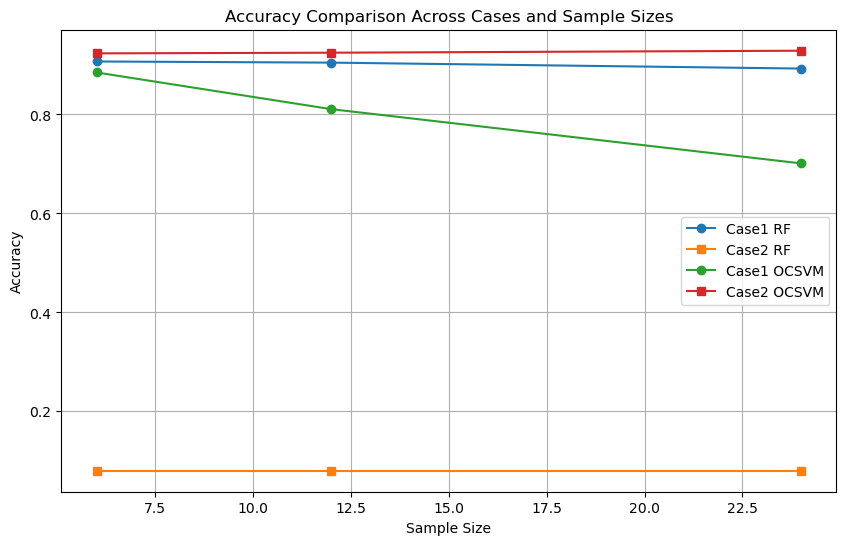

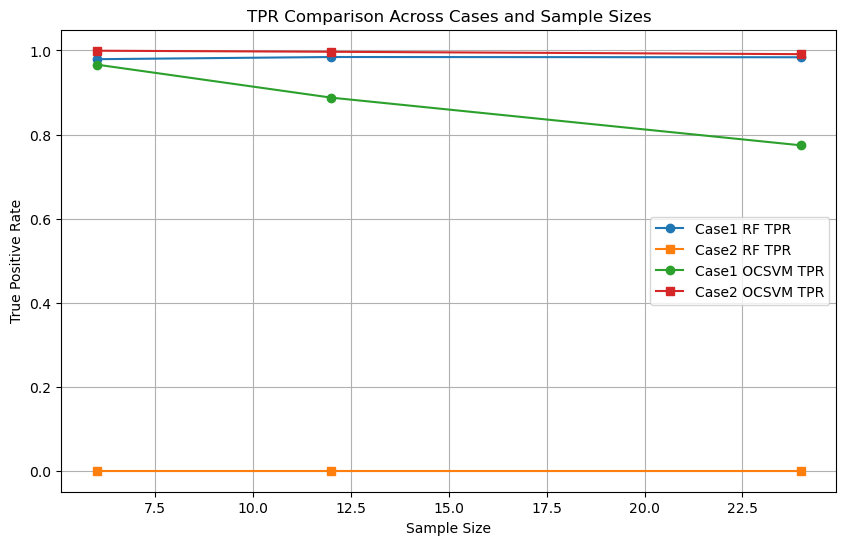

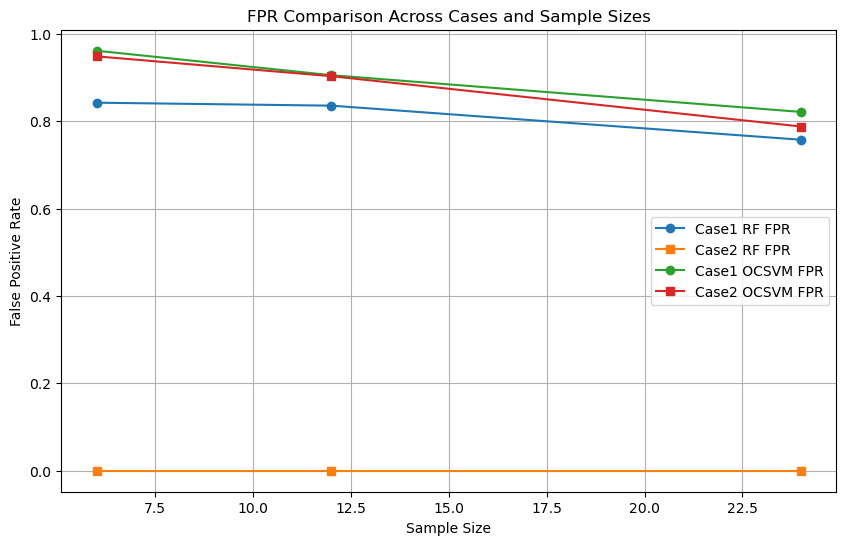

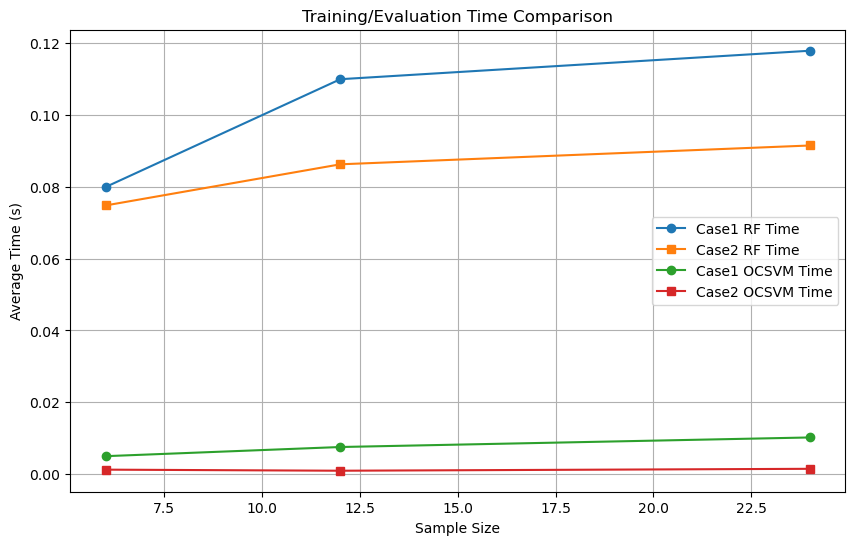


Results saved to comparative_results.csv

=== Summary Averages ===
                        Case1_Acc  Case1_TPR  Case1_FPR  Case1_Time  \
Sample Size Classifier                                                
6           OCSVM        0.884884   0.966313   0.961364    0.004956   
            RF           0.907089   0.979219   0.842424    0.079937   
12          OCSVM        0.810685   0.887641   0.905303    0.007508   
            RF           0.904803   0.984371   0.835606    0.109992   
24          OCSVM        0.701151   0.774199   0.821212    0.010171   
            RF           0.892787   0.983781   0.757576    0.117926   

                        Case2_Acc  Case2_TPR  Case2_FPR  Case2_Time  
Sample Size Classifier                                               
6           OCSVM        0.923515   0.999341   0.948485    0.001201  
            RF           0.080000   0.000000   0.000000    0.074810  
12          OCSVM        0.924848   0.996838   0.903030    0.000901  
            R

In [7]:
if __name__ == "__main__":
    main()